#  ***** Climate Analysis and Exploration of the Data! *****

In [1]:
#Import all the dependencies for Python, pandas/matplot etc, dates, and ORM functions (SQLalchemy).

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import datetime as dt

import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

from flask import Flask, jsonify

In [2]:
# Using our SQlite database created just prior, (hawaii),
# ..  we now create the engine:

engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`

Base = automap_base()

In [4]:
# Now we use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# Print all of the classes mapped to the Base

Base.classes.keys()

# *** "STATION" (singular) is an old class that was accidentally created before editing the last portion.
#  Will try and delete later if psb.   "STATIONS" (PLURAL) should be the good one, etc....
#  If it won't delete after re-running kernals, will just have to ignore for now.  MY Apologies 
# ...for any confusion.  

['measurements', 'station', 'stations']

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurements', 'station', 'stations']

In [7]:
# Use `engine.execute` to select and output our chosen vacation day-time period of around 15 days.

engine.execute('SELECT * FROM measurements LIMIT 15').fetchall()

# It picks the first 15 days of january for which data was collected.  (remember any missing days
# that are not in sequence may have resulted from the 1400 est data points missing from prcp, etc)

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (6, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (7, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (8, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (9, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (10, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (11, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (12, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (13, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (14, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (15, 'USC00519397', '2010-01-18', 0.0, 72.0)]

In [8]:
# Reflect Database into ORM class

Stations = Base.classes.stations
Measurements = Base.classes.measurements

In [9]:
# Now we start our query-session so we can query the database!

session = Session(engine)

#  ***** PRECIPITATION ANALYSIS*****

In [10]:
#  Select the last 12 months of precipitation data:

# Grabs the last date entry in the data table.   
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

(datetime.date(2017, 8, 23),)


In [11]:
# Now we need to grab 1 year back, from the last data available (above)..
# ... iE we need to get the last 12 months of data, last date - 365:

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# Now query to pull the last YEAR of precipitation data

rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [13]:
# Now we load the data from the query into a pandas DF:

# call it "rain_df":

rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [14]:
# Now let's clean up and change the index column to just be the actual data column, instead:


rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


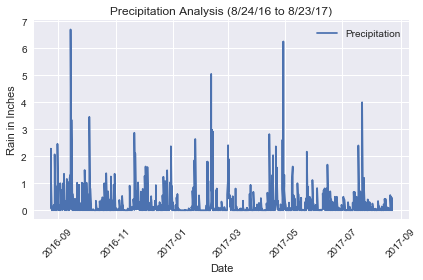

In [15]:
# Now we plot using the generic / pandas method: "plot"

rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sorry it's a little crunched together -- can't seem to get to show with wider x axis spacing, for some reason :(
# But we can at least still see where the data clusters....

In [16]:
# Now we use Pandas to print the summary statistics for the precipitation data-- IE, the describe function.

rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#   *** STATION ANALYSIS ****


In [17]:
# Count the number of stations in the Measurement table
locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [18]:
# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00513117 had 2696 weather observations.
Station USC00519397 had 2685 weather observations.
Station USC00519523 had 2572 weather observations.
Station USC00516128 had 2484 weather observations.
Station USC00514830 had 1937 weather observations.
Station USC00511918 had 1932 weather observations.
Station USC00517948 had 683 weather observations.
Station USC00518838 had 342 weather observations.


In [19]:
# Now from the busiest one, we now query to pull the last year of precipitation data.
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

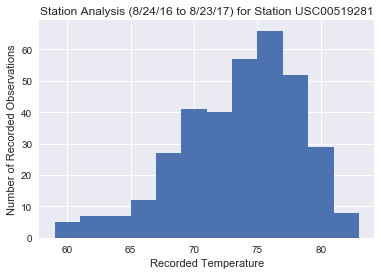

In [20]:
# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()

# **** TEMPERATURE ANALYSIS *******

In [23]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

#Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the 
#matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
print(calc_temps('2010-01-01', '2010-01-18'))

[(56.0, 68.87068965517241, 77.0)]


In [24]:
# calculate the min/max/avg from last year that matches my trip dates between 01-01-10 and 01-18-10
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(67.0, 74.39080459770115, 82.0)]


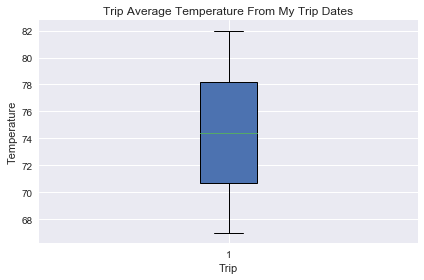

In [30]:
# We will plot the data as a boxplot to better see the range.  

fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Trip Average Temperature From My Trip Dates')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()